In [1]:
import os
import torch

from terratorch import BACKBONE_REGISTRY

/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.3 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


Check out the quick start in the docs for more details.

# Backbone factory

In [2]:
print([model_name for model_name in BACKBONE_REGISTRY if "terratorch_prithvi" in model_name])

['terratorch_prithvi_eo_tiny', 'terratorch_prithvi_eo_v1_100', 'terratorch_prithvi_eo_v2_300', 'terratorch_prithvi_eo_v2_600', 'terratorch_prithvi_eo_v2_300_tl', 'terratorch_prithvi_eo_v2_600_tl', 'terratorch_prithvi_vit_tiny', 'terratorch_prithvi_vit_100']


In [3]:
"prithvi_vit_100" in BACKBONE_REGISTRY

True

In [4]:
model = BACKBONE_REGISTRY.build("prithvi_vit_100")

/home/jalmeida/Projetos/opensource/terratorch/terratorch/models/backbones/prithvi_vit.py:339: FutureWarning: The model prithvi_vit_100 was renamed to prithvi_eo_v1_100. prithvi_vit_100 will be removed in a future version.
  warnings.warn("The model prithvi_vit_100 was renamed to prithvi_eo_v1_100. "
INFO:terratorch.models.backbones.prithvi_vit:Model bands not passed. Assuming bands are ordered in the same way as [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_NARROW: 'NIR_NARROW'>, <HLSBands.SWIR_1: 'SWIR_1'>, <HLSBands.SWIR_2: 'SWIR_2'>].Pretrained patch_embed layer may be misaligned with current bands


## The model
The resulting model is a torch module, but only the encoder (backbone) portion.

In this case, it comes from the underlying timm registry, and is wrapped in a `TimmBackboneWrapper`.

By default, the model is instantiated with the same bands it was pretrained on, with the same order.

We can inspect both of these.

In [6]:
print(f"The model was pretrained on bands {model.pretrained_bands}.\n The model is using bands {model.model_bands}")

The model was pretrained on bands [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_NARROW: 'NIR_NARROW'>, <HLSBands.SWIR_1: 'SWIR_1'>, <HLSBands.SWIR_2: 'SWIR_2'>].
 The model is using bands [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_NARROW: 'NIR_NARROW'>, <HLSBands.SWIR_1: 'SWIR_1'>, <HLSBands.SWIR_2: 'SWIR_2'>]


The model output is a list with the output of each encoder stage. This may be different for each encoder.

In [7]:
trial_data = torch.zeros(1, 6, 224, 224) # batch_size, channels, height, width
features = model(trial_data)
for index, feature in enumerate(features):
    print(f"Feature index {index} has shape {feature.shape}")

Feature index 0 has shape torch.Size([1, 197, 768])
Feature index 1 has shape torch.Size([1, 197, 768])
Feature index 2 has shape torch.Size([1, 197, 768])
Feature index 3 has shape torch.Size([1, 197, 768])
Feature index 4 has shape torch.Size([1, 197, 768])
Feature index 5 has shape torch.Size([1, 197, 768])
Feature index 6 has shape torch.Size([1, 197, 768])
Feature index 7 has shape torch.Size([1, 197, 768])
Feature index 8 has shape torch.Size([1, 197, 768])
Feature index 9 has shape torch.Size([1, 197, 768])
Feature index 10 has shape torch.Size([1, 197, 768])
Feature index 11 has shape torch.Size([1, 197, 768])


## Band choice
Sometimes you may wish to use a separate set of bands than was used in pretraining. This may be a different ordering, a subset, a superset, or a completely different set.

To do this, you may specify the bands you wish to train on using a mixture of integers and members of the `HLSBands` enum.

In the patch embed layer, the weights corresponding to bands that exist in the pretrained bands will be mapped to the correct order. Bands that do not exist will be randomly initialized.

In [8]:
from terratorch.datasets import HLSBands

# lets get only the RGB bands, and put them in that order rather than BGR, and lets add an extra band not in HLSBands
bands = [HLSBands.RED, HLSBands.GREEN, HLSBands.BLUE, 14]
model = BACKBONE_REGISTRY.build( # let's use a vit model this time
    "prithvi_vit_100", num_frames=1, pretrained=True, bands=bands
)

INFO:root:Loaded weights for HLSBands.RED in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.BLUE in position 2 of patch embed


In [9]:
# the model now expects 4 channels, not 6
trial_data = torch.zeros(1, 4, 224, 224) # batch_size, channels, height, width
features = model(trial_data)
for index, feature in enumerate(features):
    print(f"Feature index {index} has shape {feature.shape}")

Feature index 0 has shape torch.Size([1, 197, 768])
Feature index 1 has shape torch.Size([1, 197, 768])
Feature index 2 has shape torch.Size([1, 197, 768])
Feature index 3 has shape torch.Size([1, 197, 768])
Feature index 4 has shape torch.Size([1, 197, 768])
Feature index 5 has shape torch.Size([1, 197, 768])
Feature index 6 has shape torch.Size([1, 197, 768])
Feature index 7 has shape torch.Size([1, 197, 768])
Feature index 8 has shape torch.Size([1, 197, 768])
Feature index 9 has shape torch.Size([1, 197, 768])
Feature index 10 has shape torch.Size([1, 197, 768])
Feature index 11 has shape torch.Size([1, 197, 768])


# Model factory
The model factories let us create full models ready for specific tasks, including decoders and task specific heads.
They create normal `torch.nn.Module` s that you can use anywhere in your code.

Lets create a model for semantic segmentation with 4 classes

In [10]:
from terratorch.models import EncoderDecoderFactory

model_factory = EncoderDecoderFactory()

# Let's build a segmentation model
# Parameters prefixed with backbone_ get passed to the backbone
# Parameters prefixed with decoder_ get passed to the decoder
# Parameters prefixed with head_ get passed to the head

model = model_factory.build_model(task="segmentation",
        backbone="prithvi_vit_100",
        decoder="FCNDecoder",
        backbone_bands=[
            HLSBands.BLUE,
            HLSBands.GREEN,
            HLSBands.RED,
            HLSBands.NIR_NARROW,
            HLSBands.SWIR_1,
            HLSBands.SWIR_2,
        ],
        num_classes=2,
        backbone_pretrained=True,
        backbone_num_frames=1,
        decoder_channels=128,
        head_dropout=0.2
    )

INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed


Their output is a `ModelOutput` object, including the main `output` and the output of any `auxiliary_heads`.

In [11]:
trial_data = torch.zeros(1, 6, 224, 224) # batch_size, channels, height, width
out = model(trial_data)
print(out.output.shape)

torch.Size([1, 2, 224, 224])


# Datamodule
You can create datamodules for training by creating your own subclasses of `torchgeo.datamodules.GeoDataModule` or `torchgeo.datamodules.NonGeoDataModule`.

Alternatively, leverage one of our generic data modules.

Datamodules package train, test and validation datasets as well as any transforms done.

Any [TorchGeo](https://torchgeo.readthedocs.io/en/stable/) datamodule will also be compatible with TerraTorch.

## Toy example

Let's set up a toy example for burn scar segmentation.

You can get the full dataset at https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars.

For this example, we will use a single image which we will download from the demo.



In [12]:
# cd to the notebooks dir if not there
%cd examples/notebooks/

[Errno 2] No such file or directory: 'examples/notebooks/'
/home/jalmeida/Projetos/opensource/terratorch/examples/notebooks


/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [13]:
# download the image
!wget https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-Burn-scars-demo/resolve/main/subsetted_512x512_HLS.S30.T10TGS.2018285.v1.4_merged.tif

input_file_name = "subsetted_512x512_HLS.S30.T10TGS.2018285.v1.4_merged.tif"
label_file_name = "subsetted_512x512_HLS.S30.T10TGS.2018285.v1.4.mask.tif"



7[https://huggingface.co/spaces/]87subsetted_512x512_HL 100% [=============================>]    1.22K    --.-KB/s87HTTP response 302  [https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-Burn-scars-demo/resolve/main/subsetted_512x512_HLS.S30.T10TGS.2018285.v1.4_merged.tif]
87subsetted_512x512_HL 100% [=============================>]    1.22K    --.-KB/s87Adding URL: https://cdn-lfs.hf.co/repos/1c/09/1c0948cc618defc1284e350591d02a434dcb4e42e8be4eb411c4ccbaae569c03/4680447af6e80df15616c5148a7d004d9c958905c082ea51b16c2e9e4ab29d85?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27subsetted_512x512_HLS.S30.T10TGS.2018285.v1.4_merged.tif%3B+filename%3D%22subsetted_512x512_HLS.S30.T10TGS.2018285.v1.4_merged.tif%22%3B&response-content-type=image%2Ftiff&Expires=1738952039&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczODk1MjAzOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8xYy8wOS8xYzA5NDhjYzYxOGRlZmMxMjg0

In [14]:
# organize the data directory
import shutil
import matplotlib.pyplot as plt
import rioxarray as rio

if not os.path.isdir("burn_scar_segmentation_toy"):
    os.mkdir("burn_scar_segmentation_toy")

    for data_dir in ["train_images", "test_images", "val_images"]:
        os.mkdir(os.path.join("burn_scar_segmentation_toy", data_dir))
        shutil.copy(input_file_name, os.path.join("burn_scar_segmentation_toy", data_dir, input_file_name))

    for label_dir in ["train_labels", "test_labels", "val_labels"]:
        os.mkdir(os.path.join("burn_scar_segmentation_toy", label_dir))
        shutil.copy(label_file_name, os.path.join("burn_scar_segmentation_toy", label_dir, label_file_name))

## Let's visualize the data

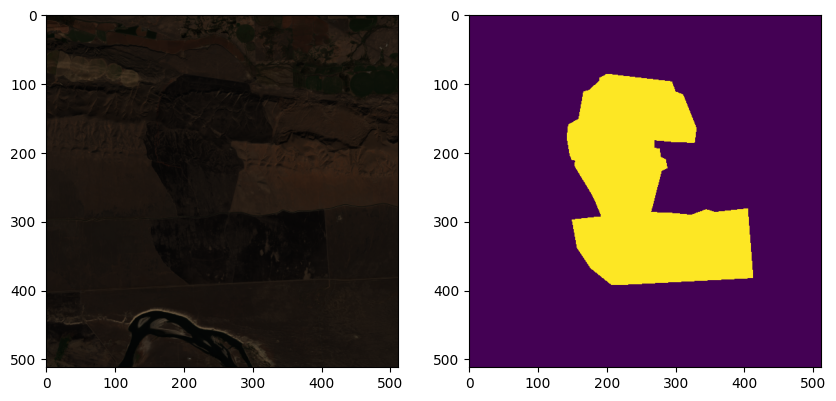

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(rio.open_rasterio(input_file_name).sel(band=[3, 2, 1]).transpose("y", "x", "band").to_numpy())
ax[1].imshow(rio.open_rasterio(label_file_name).to_numpy()[0])

In [16]:
from terratorch.datamodules import GenericNonGeoSegmentationDataModule

batch_size = 1
num_workers = 0
train_val_test = [
    "burn_scar_segmentation_toy/train_images",
    "burn_scar_segmentation_toy/val_images",
    "burn_scar_segmentation_toy/test_images",
]

train_val_test_labels = {
    "train_label_data_root": "burn_scar_segmentation_toy/train_labels",
    "val_label_data_root": "burn_scar_segmentation_toy/val_labels",
    "test_label_data_root": "burn_scar_segmentation_toy/test_labels",
}

# from https://github.com/NASA-IMPACT/hls-foundation-os/blob/main/configs/burn_scars.py
means=[
        0.033349706741586264,
        0.05701185520536176,
        0.05889748132001316,
        0.2323245113436119,
        0.1972854853760658,
        0.11944914225186566,
    ]
stds=[
        0.02269135568823774,
        0.026807560223070237,
        0.04004109844362779,
        0.07791732423672691,
        0.08708738838140137,
        0.07241979477437814,
    ]
datamodule = GenericNonGeoSegmentationDataModule(
    batch_size,
    num_workers,
    *train_val_test,
    "*_merged.tif", # img grep
    "*.mask.tif", # label grep
    means,
    stds,
    2, # num classes
    **train_val_test_labels,

    # if transforms are defined with Albumentations, you can pass them here
    # train_transform=train_transform,
    # val_transform=val_transform,
    # test_transform=test_transform,

    # edit the below for your usecase
    dataset_bands=[
        HLSBands.BLUE,
        HLSBands.GREEN,
        HLSBands.RED,
        HLSBands.NIR_NARROW,
        HLSBands.SWIR_1,
        HLSBands.SWIR_2,
    ],
    output_bands=[
        HLSBands.BLUE,
        HLSBands.GREEN,
        HLSBands.RED,
        HLSBands.NIR_NARROW,
        HLSBands.SWIR_1,
        HLSBands.SWIR_2,
    ],
    no_data_replace=0,
    no_label_replace=-1,
)
# we want to access some properties of the train dataset later on, so lets call setup here
# if not, we would not need to
datamodule.setup("fit")

# Lightning Trainers
At the highest level of abstraction, you can operate with task specific trainers. These encapsulate the model, loss, optimizer and any training hyperparameters.

They build on the model factory we introduced previously and are able to take any. To use a task with a model not supported by a currently existing model factory, simply create your own model factory!

Let's create a Trainer for Semantic Segmentation.

In [17]:

from terratorch.models.model import AuxiliaryHead
from terratorch.tasks import SemanticSegmentationTask

epochs = 1 # 1 epoch for demo
lr = 1e-3
model_args = {
        "backbone":"prithvi_vit_100",
        "decoder":"FCNDecoder",
        "num_classes": 2,
        "backbone_bands": [
            HLSBands.RED,
            HLSBands.GREEN,
            HLSBands.BLUE,
            HLSBands.NIR_NARROW,
            HLSBands.SWIR_1,
            HLSBands.SWIR_2,
        ],
        "backbone_pretrained": True,
        "backbone_num_frames":1, # this is the default
        "decoder_channels":128,
        "head_dropout":0.2,
        "necks": [
            {"name": "SelectIndices", "indices": [-1]},
            {"name": "ReshapeTokensToImage"}
        ]
}

task = SemanticSegmentationTask(
    model_args,
    "EncoderDecoderFactory",
    loss="ce",
    aux_loss={"fcn_aux_head": 0.4},
    lr=lr,
    ignore_index=-1,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.05},
)

/home/jalmeida/Projetos/opensource/terratorch/terratorch/models/backbones/prithvi_vit.py:339: FutureWarning: The model prithvi_vit_100 was renamed to prithvi_eo_v1_100. prithvi_vit_100 will be removed in a future version.
  warnings.warn("The model prithvi_vit_100 was renamed to prithvi_eo_v1_100. "
INFO:root:Loaded weights for HLSBands.RED in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.BLUE in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed


Now we can use a Lightning Trainer to train this model on the datamodule we specified

In [18]:
import os

from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

accelerator = "gpu"
experiment = "tutorial"
if not os.path.isdir("tutorial_experiments"):
    os.mkdir("tutorial_experiments")
default_root_dir = os.path.join("tutorial_experiments", experiment)
checkpoint_callback = ModelCheckpoint(monitor=task.monitor, save_top_k=1, save_last=True)
early_stopping_callback = EarlyStopping(monitor=task.monitor, min_delta=0.00, patience=20)
logger = TensorBoardLogger(save_dir=default_root_dir, name=experiment)

trainer = Trainer(
    # precision="16-mixed",
    accelerator=accelerator,
    callbacks=[
        RichProgressBar(),
        checkpoint_callback,
        LearningRateMonitor(logging_interval="epoch"),
    ],
    logger=logger,
    max_epochs=epochs, # train only one epoch for demo
    default_root_dir=default_root_dir,
    log_every_n_steps=1,
    check_val_every_n_epoch=200

)
trainer.fit(model=task, datamodule=datamodule)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA RTX A4500 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA RTX A4500 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off pre

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ PixelWiseModel   │ 87.4 M │ train │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │ train │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │
│ 4 │ test_metrics  │ ModuleList       │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 87.4 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 87.4 M                                                                                               
Total estimated model params size (MB): 349                                                                        
Modules in train mode: 323                                                                                         
Modules in eval mode: 0

/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/lightning/pytorch/trainer/conne
ctors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.

/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/lightning/pytorch/trainer/conne
ctors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.

/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [19]:
trainer.test(model=task, datamodule=datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/Multiclass_Accuracy       │          0.807342529296875          │
│      test/Multiclass_F1_Score       │          0.807342529296875          │
│    test/Multiclass_Jaccard_Index    │         0.4036712646484375          │
│ test/Multiclass_Jaccard_Index_Micro │          0.676927387714386          │
│              test/loss              │         0.5375425815582275          │
│      test/multiclassaccuracy_0      │                 1.0                 │
│      test/multiclassaccuracy_1      │                 0.0                 │
│    test/multiclassjaccardindex_0    │          0.807342529296875          │
│    test/multiclassjaccardindex_1    │                 0.0                 │
└─────────────────────────────────────┴─────────────────────────────────────┘

/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


[{'test/loss': 0.5375425815582275,
  'test/Multiclass_Accuracy': 0.807342529296875,
  'test/multiclassaccuracy_0': 1.0,
  'test/multiclassaccuracy_1': 0.0,
  'test/Multiclass_F1_Score': 0.807342529296875,
  'test/Multiclass_Jaccard_Index': 0.4036712646484375,
  'test/multiclassjaccardindex_0': 0.807342529296875,
  'test/multiclassjaccardindex_1': 0.0,
  'test/Multiclass_Jaccard_Index_Micro': 0.676927387714386}]

# Configs
Alternatively, define all this in a config file and run it through the cli. This is the reccomended approach.

Check out example config files under `examples/confs`.

```